# Federated Learning

Contributors: michaelmenzel@

## Train Base Model (on Server): Clothing Classification (with Fashion MNIST)

This example uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents: 


<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [1]:
#@title Data prep
!pip install --quiet tensorflow_federated

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow_federated as tff

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Using Tensorflow version {tf.__version__}")

(train_data, val_data), fashion_mnist_info = tfds.load("mnist:3.*.*", with_info=True, split=['train', 'test'], as_supervised=True)
class_names = fashion_mnist_info.features['label'].names
pd.DataFrame(class_names)

     |████████████████████████████████| 583kB 5.5MB/s 
     |████████████████████████████████| 174kB 8.6MB/s 
     |████████████████████████████████| 706kB 8.7MB/s 
     |████████████████████████████████| 153kB 15.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
Using Tensorflow version 2.4.1


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


### Preprocess the data


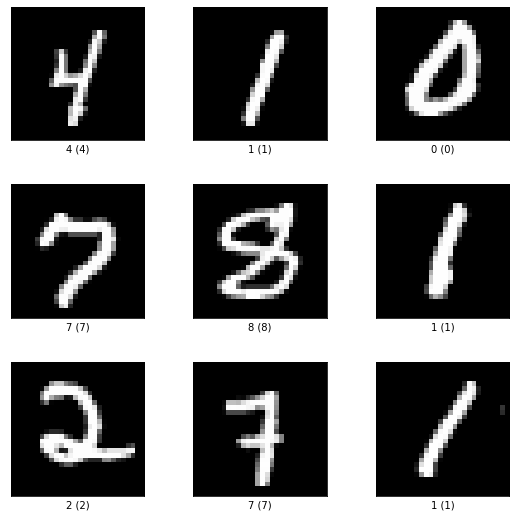

In [10]:
tfds.show_examples(train_data, fashion_mnist_info)

TRAIN_BATCH_SIZE = 300
VAL_BATCH_SIZE = 30

train_samples = train_data.map(lambda image, label: (image / 255, tf.cast(label, dtype=tf.float32))).batch(TRAIN_BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_samples = val_data.map(lambda image, label: (image / 255, tf.cast(label, dtype=tf.float32))).batch(VAL_BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)


### Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

In [13]:
model = keras.Sequential([
                keras.layers.BatchNormalization(input_shape=(28, 28, 1)),
                keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same'),
                keras.layers.ELU(),
                keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
                keras.layers.Dropout(0.25),
                keras.layers.BatchNormalization(),
                keras.layers.Conv2D(filters=128, kernel_size=(5, 5), padding='same'),
                keras.layers.ELU(),
                keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
                keras.layers.Dropout(0.25),  
                keras.layers.BatchNormalization(),
                keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='same'),
                keras.layers.ELU(),
                keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
                keras.layers.Dropout(0.25),
                keras.layers.Flatten(),
                keras.layers.Dense(256),
                keras.layers.ELU(),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(len(class_names)),
                keras.layers.Softmax()
            ])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
elu (ELU)                    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       2

### Train the model

Epoch 1/20
200/200 [==============================] - 16s 43ms/step - loss: 1.7698 - sparse_categorical_accuracy: 0.6875 - sparse_top_k_categorical_accuracy: 0.8110 - val_loss: 1.6153 - val_sparse_categorical_accuracy: 0.8454 - val_sparse_top_k_categorical_accuracy: 0.9598
Epoch 2/20
200/200 [==============================] - 8s 38ms/step - loss: 1.5057 - sparse_categorical_accuracy: 0.9553 - sparse_top_k_categorical_accuracy: 0.9940 - val_loss: 1.4831 - val_sparse_categorical_accuracy: 0.9777 - val_sparse_top_k_categorical_accuracy: 0.9987
Epoch 3/20
200/200 [==============================] - 8s 38ms/step - loss: 1.4921 - sparse_categorical_accuracy: 0.9690 - sparse_top_k_categorical_accuracy: 0.9962 - val_loss: 1.4769 - val_sparse_categorical_accuracy: 0.9842 - val_sparse_top_k_categorical_accuracy: 0.9985
Epoch 4/20
200/200 [==============================] - 8s 38ms/step - loss: 1.4867 - sparse_categorical_accuracy: 0.9742 - sparse_top_k_categorical_accuracy: 0.9972 - val_loss: 1.47

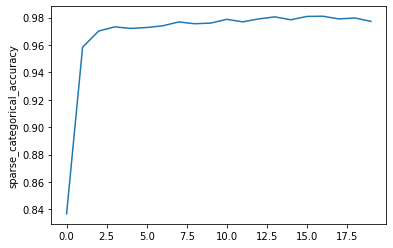

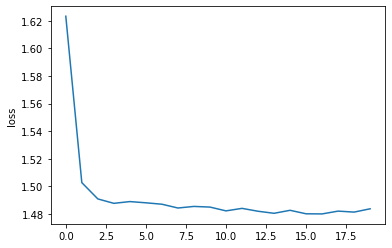

In [14]:
TRAIN_STEPS_EPOCH = int(fashion_mnist_info.splits['train'].num_examples / TRAIN_BATCH_SIZE)
VAL_STEPS_EPOCH = int(fashion_mnist_info.splits['test'].num_examples / VAL_BATCH_SIZE)


model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy(), 
                       keras.metrics.SparseTopKCategoricalAccuracy(k=3)])
history = model.fit(train_samples, validation_data=val_samples, 
                    steps_per_epoch=TRAIN_STEPS_EPOCH, validation_steps=VAL_STEPS_EPOCH, 
                    epochs=20, verbose=1)

sns.lineplot(x=range(len(history.history['sparse_categorical_accuracy'])), y='sparse_categorical_accuracy', data=history.history, legend='full')
plt.show()
sns.lineplot(x=range(len(history.history['loss'])), y='loss', data=history.history, legend='full')
plt.show()

### Evaluate model accuracy

In [ ]:
test_loss, test_acc, _ = model.evaluate(val_samples, steps=10, verbose=2)

print(f"\nTest accuracy: {test_acc}, test loss: {test_loss}")

10/10 - 0s - loss: 1.5788 - sparse_categorical_accuracy: 0.8767 - sparse_top_k_categorical_accuracy: 0.9867

Test accuracy: 0.8766666650772095, test loss: 1.5788166522979736


### Classify test samples

With the model trained, you can use it to make predictions about some images.
The model's linear outputs, [logits](https://developers.google.com/machine-learning/glossary#logits). Attach a softmax layer to convert the logits to probabilities, which are easier to interpret. 

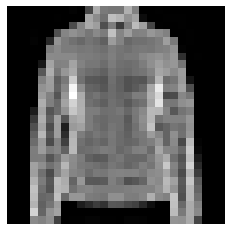

Predicted class: 'Coat', actual class: 'Coat'


In [ ]:
test_sample = list(test_samples.unbatch().take(1).as_numpy_iterator())[0]
predictions = model.predict(test_samples.take(1))

plt.imshow(np.squeeze(test_sample[0]), cmap='gray')
plt.axis('off')
plt.show()
print(f"Predicted class: '{class_names[np.argmax(predictions[0])]}', actual class: '{class_names[test_sample[1]]}'")

### Save the model

INFO:tensorflow:Assets written to: fashion-mnist-cnn.model/assets


INFO:tensorflow:Assets written to: fashion-mnist-cnn.model/assets


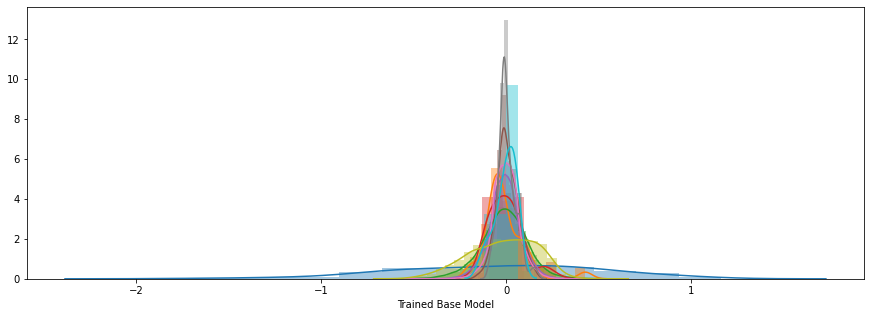

In [ ]:
model.save('fashion-mnist-cnn.model')

plt.figure(figsize=(15,5))
for weight_var in model.weights:
  sns.distplot(weight_var.value(), axlabel='Trained Base Model')
plt.show()

def load_saved_model(compile=True):
  return keras.models.load_model('fashion-mnist-cnn.model', compile=compile)

## Train Local Model (on Client)

In [ ]:
def load_base_model():
  return tff.learning.from_keras_model(
            load_saved_model(compile=False),
            input_spec=test_samples.element_spec,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
 
federated_avg = tff.learning.build_federated_averaging_process(
                  model_fn=load_base_model,
                  client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.7))
base_state = federated_avg.initialize()
client_state = base_state

16384/14342 [==================================] - 0s 0us/step


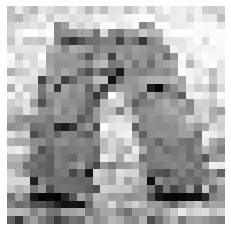

Predicted class: 'Bag', actual class: 'Trouser'
Federated training yielded updated metrics: <sparse_categorical_accuracy=0.0,loss=2.459280490875244>


In [ ]:
#@title Train with Online Image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Jeans.jpg/160px-Jeans.jpg" #@param {type:"string"}
class_name = "Trouser" #@param ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'] {type:"string"}

class_idx = class_names.index(class_name)
image_file = tf.keras.utils.get_file(origin=image_url, fname='client_image')

image = tf.keras.preprocessing.image.load_img(image_file, color_mode='grayscale', target_size=[28, 28])
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

image_tensor = tf.convert_to_tensor([tf.keras.preprocessing.image.img_to_array(image) / 255])
label_tensor = tf.convert_to_tensor([class_idx], dtype=tf.int64)
client_example = tf.data.Dataset.from_tensors((image_tensor, label_tensor))

client_predicted = load_saved_model().predict(client_example)
print(f"Predicted class: '{class_names[np.argmax(client_predicted[0])]}', actual class: '{class_name}'")

client_state, client_metrics = federated_avg.next(client_state, [client_example.take(1)])
print(f"Federated training yielded updated metrics: {client_metrics}")

## Adjust Base Model Weights (on Server)

In [ ]:
base_model = load_saved_model()
central_model = load_saved_model()
tff.learning.assign_weights_to_keras_model(central_model, client_state.model)

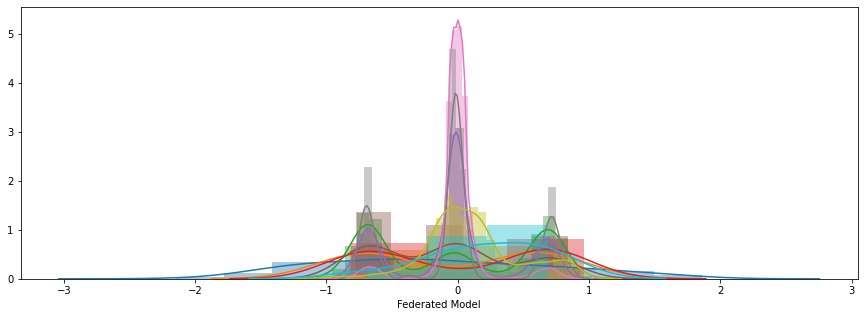

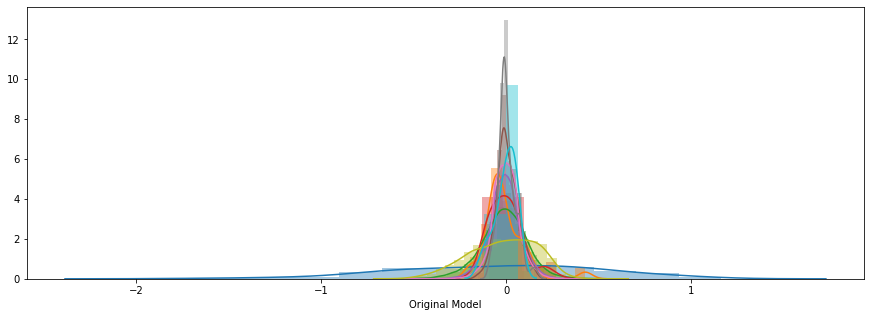

In [ ]:
plt.figure(figsize=(15,5))
for weight_var in central_model.weights:
  sns.distplot(weight_var.value(), axlabel='Federated Model')
plt.show()

plt.figure(figsize=(15,5))
for weight_var in base_model.weights:
  sns.distplot(weight_var.value(), axlabel='Original Model')
plt.show()
